<a href="https://colab.research.google.com/github/a356617605/1DCNN/blob/main/FeAl_1DCNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
%cd /content/gdrive/MyDrive/Colab Notebooks/FeAl_1DCNN

/content/gdrive/MyDrive/Colab Notebooks/FeAl_1DCNN


In [15]:
%matplotlib inline

In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import random as rd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [17]:
# Parameters
length_size = int(0.69/0.015*2+1)   #1D size
training_dir = 'Training/'   #in one folder
save_dir = 'saved_models_1CNN_layer_kernel_size_10_neuro_256_new_data_3class_multi_models/' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir) 

In [18]:
################################################################# 
#Functions
################################################################
# Data normalization from 0 to 1 for double column dataframe, returns single column array
def normdata(data):
    
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1//2])
    for i in range(w1//2):
        ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
    return ndata
# defien model name
def get_model_name(k):
    return 'model_'+str(k)+'.h5'
# Data augmendatation for simulated XRD patterns
def augdata(data,num):
    (len1,w1) = np.shape(data)
    newaugd=np.zeros([len1,num])    
    for i in range(num):
        #adding shift
        cut = np.random.randint(-4,4)
        #shift to left
        if cut>=0:
            newaugd[:,i] = np.concatenate((data[cut:93,i],np.zeros([cut,]),data[93+cut:,i],np.zeros([cut,])), axis=0)
        #shift to right
        else:
            newaugd[:,i] = np.concatenate((np.zeros([cut*-1,]), data[0:93+cut,i], np.zeros([cut*-1,]), data[93:186+cut,i]), axis=0)
       
        # #plot data augmented curve
        # fig2D = plt.figure(figsize=(4,4))                
        # ax2D = fig2D.add_subplot(111) 
        # plt.plot(sim_matrix_FeFe[:93, 0], data[:93, i],  label='Original data') 
        # plt.plot(sim_matrix_FeFe[:93, 0], newaugd[:93, i], label='Data augment')     
        # plt.legend(loc='upper right')
        
        # fig2D = plt.figure(figsize=(4,4))                
        # ax2D = fig2D.add_subplot(111) 
        # plt.plot(sim_matrix_FeFe[:93, 0], data[93:186, i],  label='Original data') 
        # plt.plot(sim_matrix_FeFe[:93, 0], newaugd[93:186, i], label='Data augment') 
        # plt.le       
    return newaugd

In [19]:
################################################################
# Load data and preprocess
################################################################

sim_matrix_FeFe = np.load(training_dir+'zSDM_simu_FeAl_BCC_FeFe.npy')
sim_matrix_AlAl = np.load(training_dir+'zSDM_simu_FeAl_BCC_AlAl.npy')
sim_matrix = np.concatenate((sim_matrix_FeFe, sim_matrix_AlAl), axis=0)
# Data normalization
nsim_matrix_FeFe = normdata(sim_matrix_FeFe)
nsim_matrix_AlAl = normdata(sim_matrix_AlAl)
nsim_matrix = np.concatenate((nsim_matrix_FeFe, nsim_matrix_AlAl), axis=0)

sim_stru_B2_FeFe = np.load(training_dir+'zSDM_simu_FeAl_B2_FeFe.npy')
sim_stru_B2_AlAl = np.load(training_dir+'zSDM_simu_FeAl_B2_AlAl.npy')
# Data normalization
nsim_stru_B2_FeFe = normdata(sim_stru_B2_FeFe)
nsim_stru_B2_AlAl = normdata(sim_stru_B2_AlAl)
nsim_stru_B2= np.concatenate((nsim_stru_B2_FeFe, nsim_stru_B2_AlAl), axis=0)

sim_stru_D03_FeFe = np.load(training_dir+'zSDM_simu_FeAl_D03_FeFe.npy')
sim_stru_D03_AlAl = np.load(training_dir+'zSDM_simu_FeAl_D03_AlAl.npy')
# Data normalization
nsim_stru_D03_FeFe = normdata(sim_stru_D03_FeFe)
nsim_stru_D03_AlAl = normdata(sim_stru_D03_AlAl)
nsim_stru_D03= np.concatenate((nsim_stru_D03_FeFe, nsim_stru_D03_AlAl), axis=0)

# Labels
label_nsim_matrix = np.zeros((nsim_matrix.shape[1], 1), dtype=int)
label_nsim_stru_B2 = np.ones((nsim_stru_B2.shape[1], 1), dtype=int)
label_nsim_stru_D03 = np.ones((nsim_stru_D03.shape[1], 1), dtype=int)+1

x_sim_ori = np.concatenate((nsim_matrix, nsim_stru_B2, nsim_stru_D03), axis=1)
y_sim_ori = np.concatenate((label_nsim_matrix, label_nsim_stru_B2, label_nsim_stru_D03), axis=0)

#Data augment
(len1, sim_num) = np.shape(x_sim_ori)
x_sim_augd= augdata(x_sim_ori, sim_num)   
y_sim_augd = y_sim_ori
# Prepare simulated arrays for training and testing
x_sim = np.concatenate((x_sim_ori, x_sim_augd), axis=1).T
y_sim = np.concatenate((y_sim_ori, y_sim_augd), axis=0)

In [20]:
################################################################
# Perform training and cross-validation
################################################################
fold = 5 # Number of k-folds
k_fold = KFold(n_splits=fold, shuffle=True)

# Create auxiliary arrays
accuracy=[]
logs=[]
ground_truth=[]
predictions_ord=[]
trains=[]
tests=[]
trains_combine=[]
trains_y=[]

# split into train, test, and another test dataset
all_sim = np.concatenate((x_sim, y_sim), axis=1)
#Data random sequence
idx = rd.sample(range(all_sim.shape[0]), all_sim.shape[0]) 
all_sim_shuttle = all_sim[idx]
train_test = all_sim_shuttle[:int(all_sim.shape[0]*0.9), :]
test_sec = all_sim_shuttle[int(all_sim.shape[0]*0.9):, :]
     
# Run cross validation
for k, (train, test) in enumerate(k_fold.split(train_test[:, :-1], train_test[:, -1])):
    print('k=', k)
    #Save splits for later use
    trains.append(train)
    tests.append(test)

    train_x = train_test[train, :-1]
    train_y = train_test[train, -1]
    test_x = train_test[test, :-1]
    test_y = train_test[test, -1]

    # Network Parameters
    BATCH_SIZE=32
    epochs=30
    n_input = 93 # 
    n_features= 2  # FeFe and ALAL
    n_classes = 3 # matrix, B2, D03

    enc = OneHotEncoder(sparse=False)
    
    # Define train data
    train_x_dim = np.stack((train_x[:, :n_input], train_x[:, n_input:]), axis=2)
    trains_y.append(train_y)
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1))
    
    # Define test data
    test_x_dim = np.stack((test_x[:, :n_input], test_x[:, n_input:]), axis=2)
    test_y_hot = enc.fit_transform(test_y.reshape(-1,1))
    
    # Define network structure
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64, 10, strides=1, padding='valid',input_shape=(n_input, n_features), activation='relu'),   
            # tf.keras.layers.Conv1D(128, 10, strides=1, padding='valid', activation='relu'),   
            tf.keras.layers.Dropout(0.5),   
            tf.keras.layers.MaxPool1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(n_classes, activation='softmax')
            ])
     
    # Compile model
    Optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Optimizer,
                  metrics=['accuracy'])
    
    # Fit model
    history = model.fit(train_x_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=epochs,
                      verbose=0, validation_data=(test_x_dim, test_y_hot))

    #save model
    model_path = os.path.join(save_dir, get_model_name(k))
    model.save(model_path)

k= 0
k= 1
k= 2
k= 3
k= 4


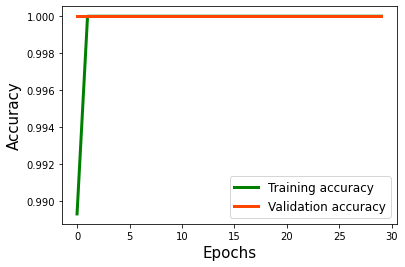

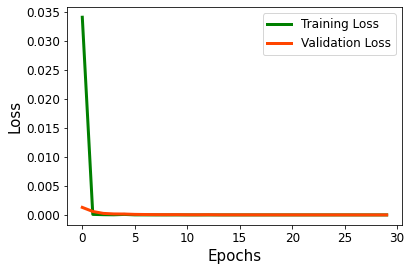

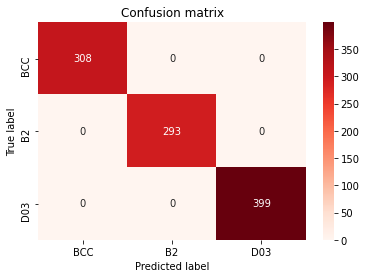

In [21]:
#plot results   
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure() 
plt.plot(epochs, acc, c='green', linewidth=3, label='Training accuracy')
plt.plot(epochs, val_acc, c='orangered', linewidth=3, label='Validation accuracy')
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend(loc='lower right', fontsize=12)
      
fig = plt.figure() 
plt.plot(epochs, loss, c='green', linewidth=3, label='Training Loss')
plt.plot(epochs, val_loss, c='orangered', linewidth=3, label='Validation Loss')
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)  

################################################################
# Test using simulated data
################################################################
test_sec_x, test_sec_y = test_sec[:, :-1], test_sec[:, -1]
test_sec_y_hot = enc.fit_transform(test_sec_y.reshape(-1,1))
test_sec_x_dim = np.stack((test_sec_x[:, :n_input], test_sec_x[:, n_input:]), axis=2)
test_sec_y_predictions = model.predict(test_sec_x_dim[:,:,:]) 

#Plotting a Confusion Matrix
matrix = confusion_matrix(test_sec_y_hot.argmax(axis=1), test_sec_y_predictions.argmax(axis=1))    
cm_plot_labels = ['BCC','B2','D03']
df_cm = pd.DataFrame(matrix, index = [i for i in cm_plot_labels],
                  columns = [i for i in cm_plot_labels])
plt.figure()
plt.title('Confusion matrix')
sn.heatmap(df_cm, cmap=plt.cm.Reds, annot=True, fmt="d")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
# break